Signal Decomposition: ML algorithms
Author: Javier Gamero Muñoz

In this notebook a few ML models will be applied to the preprocessed data in 
order to try to decompose the total time serie in two, one from the $\mu$ and 
another for the $e$.

# General Libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
idx_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
idxs = pd.read_csv(idx_path, sep=';', header=None)
idxs = np.array(idxs.iloc[:,0]).reshape(-1)
idxs

array(['0_1', '0_4', '0_6', ..., '399_42', '399_43', '399_48'],
      dtype=object)

In [4]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [5]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [6]:
t = np.array(t.iloc[0, t_idx]).reshape(-1) #1D array from t0 and on

In [7]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None)
e_signals.set_index(0, inplace=True)
e_signals = e_signals.loc[idxs, :] # take only those with the electron

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None)
mu_signals.set_index(0, inplace=True)
mu_signals = mu_signals.loc[idxs, :] # take only those with the electron

# total signal: 
signals = mu_signals + e_signals

Function to create fasts plots of signals: 

In [8]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v))
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure()
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return

0_9


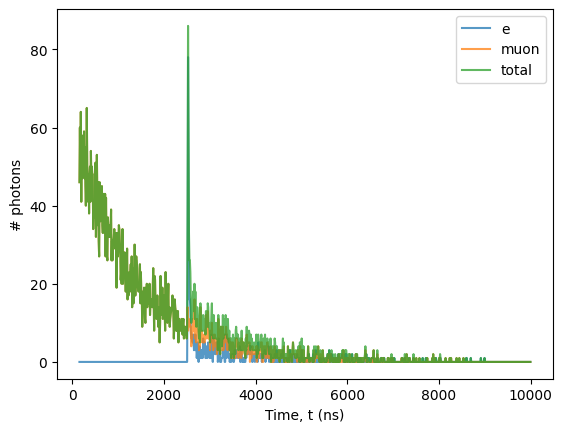

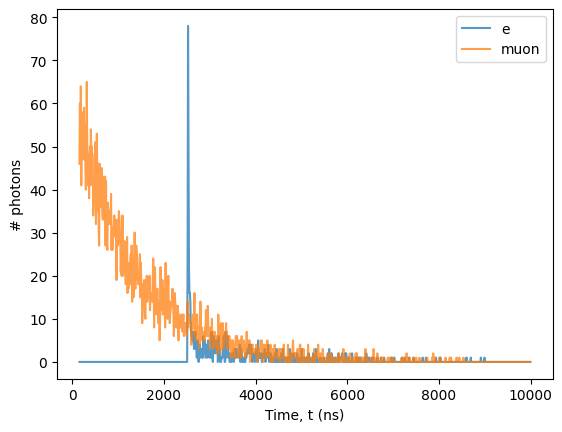

In [9]:
i = 4
print(idxs[i])
e_signal = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1)
signal = np.array(signals.loc[idxs[i], t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t, v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t, v, ['e', 'muon'])

# Processing data

Here, we structure data so algorithms can make use of them. 

In [10]:
X = np.array(signals.iloc[:, t_idx].values)
y = np.array(e_signals.iloc[:, t_idx].values)
X.shape

(9325, 985)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

Also, we process another stack of data removing signals whose max peak is lower 
than a threshold `max_photons`.

In [12]:
max_photons = 5
max_values = e_signals.max(axis=1)

mask = max_values > max_photons # True those with a maximum > max_photons
e_idxs = mask[mask==True].index.values

print('Total series: ', e_signals.shape[0])
print('Number of e signals with a max>{0}: {1}'.format(max_photons, e_idxs.shape[0]))

Total series:  9325
Number of e signals with a max>5: 4223


In [13]:
Xf = np.array(signals.loc[e_idxs, t_idx].values)
yf = np.array(e_signals.loc[e_idxs, t_idx].values)

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, 
                                                    test_size=0.3,
                                                    random_state=2023)

# ML Algorithms

## KNN

We begin with K-Nearest-Neighbours (KNN) algorithm from `sklearn`.  
Since this problem is trying to decompose a signal, it will be treated as a 
regression one. 

In [14]:
from sklearn.neighbors import KNeighborsRegressor

m0 = time()
knn = KNeighborsRegressor() # by default to check if it works
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Time spent training and predicting: {0}(s)'.format(time()-m0))

Time spent training and predicting: 0.48767828941345215(s)


In [15]:
y_pred.shape

(2798, 985)

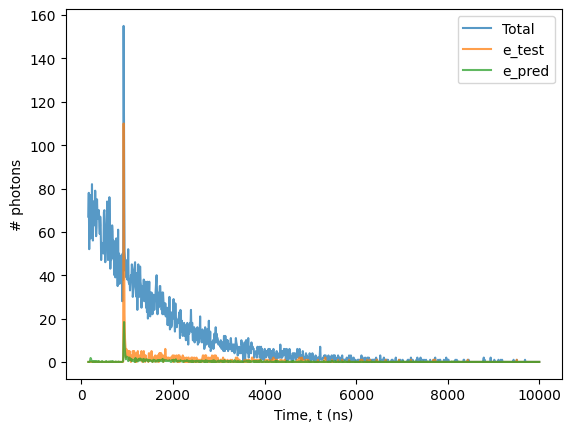

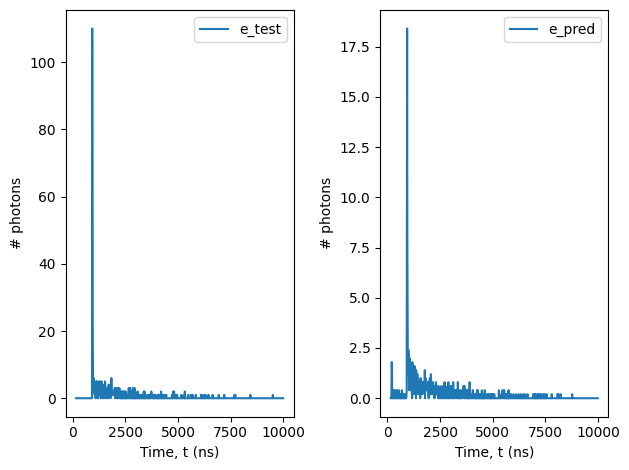

In [16]:
i = 12

v = [X_test[i,:], y_test[i,:], y_pred[i,:]]
plotSignals(t, v, ['Total', 'e_test', 'e_pred'], sep=False)

v = [y_test[i,:], y_pred[i,:]]
plotSignals(t, v, ['e_test', 'e_pred'], sep=True)

In [17]:
e_found = 0
for GT, pred in zip(y_test, y_pred): 
    q = quality(t, GT, pred)
    if q.isElectronExctracted(): e_found+=1
    
print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

Ratio e total found: 30.950679056468903%


Let's try a 10-fold cross validation:

In [18]:
m0 = time()

knn = KNeighborsRegressor()
qual = quality(t)
r_train, r_test = qual.cross_validate(knn, X, y)

print('\nTime spent in cross-validation: {0}(s)'.format(time()-m0))

print('\nMean ratio of e found in test: {0}%'.format(np.mean(r_test)*100))
print('Mean ratio of e found in train: {0}%'.format(np.mean(r_train)*100))

Iterations of cv: 1/5
Iterations of cv: 2/5
Iterations of cv: 3/5
Iterations of cv: 4/5
Iterations of cv: 5/5

Time spent in cross-validation: 8.295193672180176(s)

Mean ratio of e found in test: 32.38605898123325%
Mean ratio of e found in train: 63.35120643431635%


As we can see, the algorithm is failing to find the most of electrons and, also, 
it seems to be overfitting.  

First problem could happen due to the low signal of the electron in comparison with the 
total serie. Hence we use the data filtered, with signals where the $e$ does 
not have a maximum of 5 photons in one moment have been removed:

In [19]:
knn = KNeighborsRegressor() # by default to check if it works
knn.fit(Xf_train, yf_train)
yf_pred = knn.predict(Xf_test)

e_found = 0
for GT, pred in zip(yf_test, yf_pred): 
    q = quality(t, GT, pred)
    if q.isElectronExctracted(): e_found+=1
    
print('Ratio e total found: {0}%'.format(e_found / yf_test.shape[0] * 100))

Ratio e total found: 38.910812943962114%


Cross validation: 

In [20]:
m0 = time()

knn = KNeighborsRegressor()
qual = quality(t)
r_train, r_test = qual.cross_validate(knn, Xf, yf)

print('\nTime spent in cross-validation: {0}(s)'.format(time()-m0))

print('\nMean ratio of e found in test: {0}%'.format(np.mean(r_test)*100))
print('Mean ratio of e found in train: {0}%'.format(np.mean(r_train)*100))

Iterations of cv: 1/5
Iterations of cv: 2/5
Iterations of cv: 3/5
Iterations of cv: 4/5
Iterations of cv: 5/5

Time spent in cross-validation: 2.4486429691314697(s)

Mean ratio of e found in test: 39.171597633136095%
Mean ratio of e found in train: 71.28478389579634%


The problems have not dissapear.  
Let's try a GridSearch around the parameters, creating a table to see what 
configuration is the best and if, the result may be enhanced.

In [21]:
n_neighbors=[3,4,5]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.getScore(knn, X, y)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, r_train, r_result))

N neighbors: 3, metric: cityblock, trainScore: 0.7509383378016086, testScore: 0.2675603217158177
N neighbors: 3, metric: cosine, trainScore: 0.6310991957104558, testScore: 0.303485254691689
N neighbors: 3, metric: euclidean, trainScore: 0.7348525469168901, testScore: 0.34959785522788206
N neighbors: 4, metric: cityblock, trainScore: 0.6848525469168901, testScore: 0.24986595174262735
N neighbors: 4, metric: cosine, trainScore: 0.5603217158176944, testScore: 0.2809651474530831
N neighbors: 4, metric: euclidean, trainScore: 0.6733243967828418, testScore: 0.33404825737265414
N neighbors: 5, metric: cityblock, trainScore: 0.6361930294906166, testScore: 0.24450402144772118
N neighbors: 5, metric: cosine, trainScore: 0.5203753351206434, testScore: 0.2707774798927614
N neighbors: 5, metric: euclidean, trainScore: 0.6335120643431635, testScore: 0.32386058981233246


It does not improve in any case...  
Cross validation for a better statistical result.

In [22]:
n_neighbors=[3,4,5]
metrics=['cityblock', 'cosine', 'euclidean']
e_found=0

q = quality(t)
for n in n_neighbors:
    for metric in metrics: 
        knn = KNeighborsRegressor(n_neighbors=n, metric=metric, n_jobs=-1)
        r_train, r_result = q.cross_validate(knn, X, y, verbose=0)
        print('N neighbors: {0}, metric: {1}, trainScore: {2}, testScore: {3}'.format(n, metric, np.mean(r_train), np.mean(r_result)))

N neighbors: 3, metric: cityblock, trainScore: 0.7509383378016086, testScore: 0.2675603217158177
N neighbors: 3, metric: cosine, trainScore: 0.6310991957104558, testScore: 0.303485254691689
N neighbors: 3, metric: euclidean, trainScore: 0.7348525469168901, testScore: 0.34959785522788206
N neighbors: 4, metric: cityblock, trainScore: 0.6848525469168901, testScore: 0.24986595174262732
N neighbors: 4, metric: cosine, trainScore: 0.5603217158176944, testScore: 0.2809651474530831
N neighbors: 4, metric: euclidean, trainScore: 0.6733243967828418, testScore: 0.33404825737265414
N neighbors: 5, metric: cityblock, trainScore: 0.6361930294906166, testScore: 0.24450402144772115
N neighbors: 5, metric: cosine, trainScore: 0.5203753351206434, testScore: 0.2707774798927614
N neighbors: 5, metric: euclidean, trainScore: 0.6335120643431635, testScore: 0.32386058981233246


## SVM

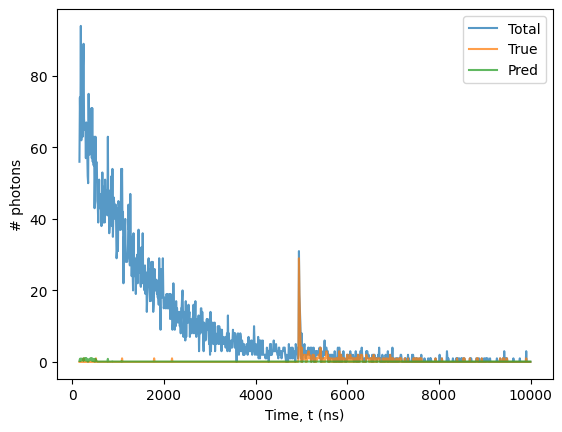

In [14]:
from sklearn.svm import SVR

i = 5
q = quality(t)
svm = SVR(kernel='rbf', C=1.0)
svm.fit(X_train[i,:].reshape(-1,1), y_train[i,:])
y_pred = svm.predict(X_train[8,:].reshape(-1,1))

v = [X_train[8,:], y_train[8,:], y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'])

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1],
    'epsilon': [0.1, 0.2],
    'gamma': ['scale'] 
}

i=8

svm = SVR()
gs = GridSearchCV(svm, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1,
                  verbose=0)
gs.fit(X_train[i,:].reshape(-1,1), y_train[i,:])

best_params = gs.best_params_
best_svr = gs.best_estimator_

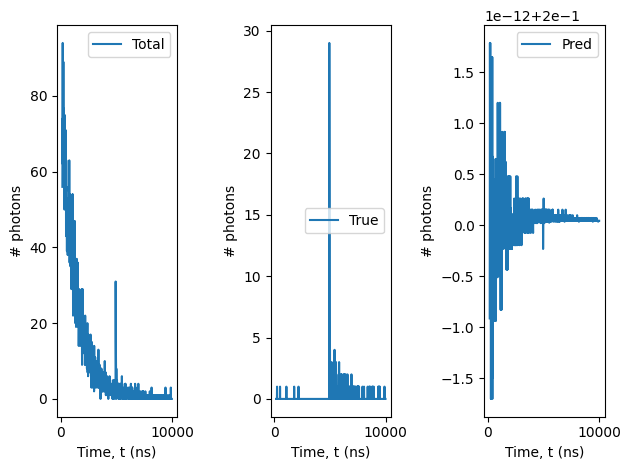

{'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}


In [58]:
j = 8
y_pred = best_svr.predict(X_train[j,:].reshape(-1,1))

v = [X_train[j,:], y_train[j,:], y_pred]
plotSignals(t, v, ['Total', 'True', 'Pred'], sep=True)
print(best_params)

In [25]:
param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1],
    'epsilon': [0.1, 0.2],
    # 'gamma': ['scale'] 
}

svm = SVR()
gs = GridSearchCV(svm, param_grid, cv=2, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=0)

params = []
for i in range(Xf_train.shape[0]): 
    gs.fit(Xf_train[i,:].reshape(-1,1), yf_train[i,:])
    params.append(gs.best_estimator_)
    print(i, gs.best_estimator_)

0 SVR(C=1, kernel='poly')
1 SVR(C=0.1)
2 SVR(C=0.1)
3 SVR(C=0.1, epsilon=0.2)
4 SVR(C=1, epsilon=0.2)
5 SVR(C=0.1, epsilon=0.2)
6 SVR(C=1, epsilon=0.2)
7 SVR(C=0.1, kernel='poly')
8 SVR(C=0.1, epsilon=0.2)
9 SVR(C=0.1)
10 SVR(C=0.1, epsilon=0.2)
11 SVR(C=0.1, epsilon=0.2)
12 SVR(C=0.1, epsilon=0.2)
13 SVR(C=0.1, epsilon=0.2)
14 SVR(C=0.1, epsilon=0.2)
15 SVR(C=0.1)
16 SVR(C=1, epsilon=0.2)
17 SVR(C=0.1, epsilon=0.2, kernel='poly')
18 SVR(C=1, epsilon=0.2, kernel='poly')
19 SVR(C=0.1)
20 SVR(C=1, epsilon=0.2)
21 SVR(C=1, epsilon=0.2, kernel='poly')
22 SVR(C=0.1, epsilon=0.2)
23 SVR(C=1, epsilon=0.2)
24 SVR(C=1)
25 SVR(C=1, epsilon=0.2)
26 SVR(C=0.1, epsilon=0.2)
27 SVR(C=0.1, kernel='poly')
28 SVR(C=1, epsilon=0.2, kernel='poly')
29 SVR(C=0.1)
30 SVR(C=0.1, epsilon=0.2)
31 SVR(C=0.1, epsilon=0.2)
32 SVR(C=0.1, epsilon=0.2)
33 SVR(C=0.1)
34 SVR(C=1, epsilon=0.2)
35 SVR(C=0.1)
36 SVR(C=0.1, epsilon=0.2)
37 SVR(C=0.1, epsilon=0.2)
38 SVR(C=1, epsilon=0.2)
39 SVR(C=1, kernel='poly')
40 SVR(

KeyboardInterrupt: 

This approach is not efficient enough... and there are no proof that it is 
capable of obtaining good results even in the trained data.